# Import all neccessary libraries

In [145]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import models
from torchvision.utils import save_image

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [146]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Load 'content' and 'style' images from provided paths

In [147]:
std = torch.tensor([0.229, 0.224, 0.225], device=device).view(-1, 1, 1)
mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(-1, 1, 1)

def image_loader(path, transform):
    img = Image.open(path)
    img = transform(img).unsqueeze(0).to(device, torch.float)
    return img

def Normalize(image):
  image = image - mean
  image = image / std

  return image

def Denormalize(image):
  image = image * std
  image = image + mean

  return image

In [148]:
image_size = (256, 256)

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

content_image = image_loader('Style.png', transform).detach()
style_image = image_loader('udnie.png', transform).detach()
content_image = Normalize(content_image)
style_image = Normalize(style_image)
gen_image = content_image.clone().requires_grad_(True)

## Display images

In [149]:
def plot_image(images, names=None, denorm=False):

  if type(images) is list:
    plt.figure(figsize=(5 * len(images), 8))

    for i in range(len(images)):
      if denorm:
        image = images[i] * std + mean
      else:
        image = images[i]

      plt.subplot(1, len(images), i + 1)

      if names == None:
        plt.title('Image {}'.format(i))
      else:
        plt.title(names[i])

      plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu())
      plt.axis('off')

    plt.show()
  else:
    if denorm:
      image = images * std + mean
    else:
      image = images

    plt.figure(figsize=(4, 8))

    plt.subplot(1, 1, 1)
    plt.title('Content Image')
    plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu())
    plt.axis('off')

    plt.show()

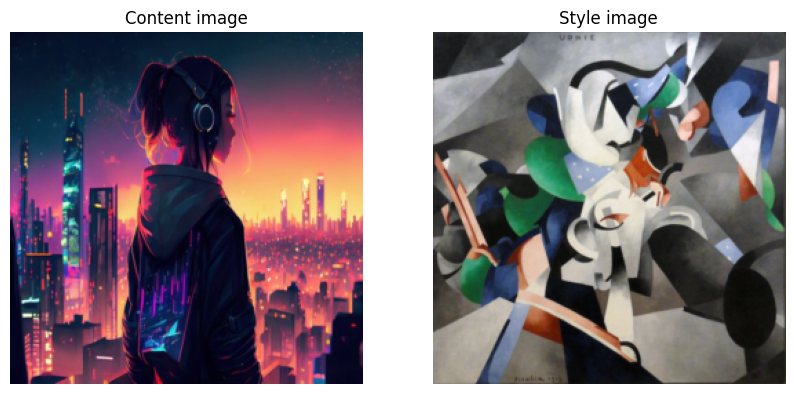

In [150]:
plot_image([content_image, style_image], names=['Content image', 'Style image'], denorm=True)

# Define the Model

In [151]:
model = models.vgg19(pretrained=True).features

In [152]:
for layer_num, layer in enumerate(model):
  print(layer_num, layer)

0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 ReLU(inplace=True)
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 ReLU(inplace=True)
4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 ReLU(inplace=True)
7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 ReLU(inplace=True)
9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
10 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 ReLU(inplace=True)
12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13 ReLU(inplace=True)
14 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15 ReLU(inplace=True)
16 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
17 ReLU(inplace=True)
18 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
19 Conv2d(256, 512, kernel_size=(3, 3)

In [153]:
style_conv = ['0', '5', '7', '10', '21']
content_conv = ['2']
all_conv = ['0', '2', '5', '7', '10', '12', '14', '16', '19', '21', '28', '30', '32', '34']

In [154]:
# models/vgg19.py

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()

        self.req_features = all_conv
        self.model = models.vgg19(pretrained=True).features

    def forward(self, x):
        features = []
        for layer_num, layer in enumerate(self.model):
            x = layer(x)
            if str(layer_num) in self.req_features:
                features.append(x)

        return features

# Loss Function

In [155]:
# loss/content_loss.py
def content_loss(gen_feat, content_feat):
    return torch.mean((gen_feat - content_feat) ** 2)

# loss/style_loss.py
def style_loss(gen_feat, style_feat):
    batch_size, channel, height, width = gen_feat.shape

    G = torch.mm(
        gen_feat.view(channel, height * width),
        gen_feat.view(channel, height * width).t()
    )

    A = torch.mm(
        style_feat.view(channel, height * width),
        style_feat.view(channel, height * width).t()
    )

    return torch.mean((G - A) ** 2)# / ((channel * height * width) ** 2)

# loss/loss.py
def criterion(gen_feat, content_feat, style_feat, alpha, beta):
    style_loss_total = 0
    content_loss_total = 0
    for i in range(len(all_conv)):
      if all_conv[i] in content_conv:
        content_loss_total += content_loss(gen_feat[i], content_feat[i])

      if all_conv[i] in style_conv:
        style_loss_total += style_loss(gen_feat[i], style_feat[i])

    return (alpha * content_loss_total + beta * style_loss_total)

# Configure the parameters

In [156]:
epochs = 2000
lr = 1e-3
alpha = 1
beta = 1e3
verbose = 20


model = VGG().to(device).eval()
optimizer = torch.optim.Adam([gen_image], lr=lr)

# Train the Model

In [157]:
loss_history = []
gen_images = []
for epoch in range(epochs):
    gen_feat = model(gen_image)
    content_feat = model(content_image)
    style_feat = model(style_image)

    optimizer.zero_grad()
    loss = criterion(gen_feat, content_feat, style_feat, alpha, beta)

    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if verbose > 0 and (epoch + 1) % verbose == 0:
        print(f"Epoch: {epoch + 1}/{epochs}, loss: {loss.item()}")

    if (epoch + 1) % 100 == 0:
        img_save = Denormalize(gen_image.detach())
        img_save = img_save.squeeze(0).permute(1, 2, 0).cpu()
        img_save = (img_save.numpy().clip(0, 1) * 255).astype(np.uint8)
        gen_images.append(img_save)

print('Training Finished!')
save_image(gen_image, 'gen.png')
save_image(content_image, 'content.png')
save_image(style_image, 'style_image.png')
print('Generated image saved as `gen.png`')

Epoch: 20/2000, loss: 1004789366784.0
Epoch: 40/2000, loss: 840372453376.0
Epoch: 60/2000, loss: 725619834880.0
Epoch: 80/2000, loss: 638654218240.0
Epoch: 100/2000, loss: 570100023296.0
Epoch: 120/2000, loss: 514541584384.0
Epoch: 140/2000, loss: 468546420736.0
Epoch: 160/2000, loss: 429760577536.0
Epoch: 180/2000, loss: 396480380928.0
Epoch: 200/2000, loss: 367482765312.0
Epoch: 220/2000, loss: 342011936768.0
Epoch: 240/2000, loss: 319486361600.0
Epoch: 260/2000, loss: 299366449152.0
Epoch: 280/2000, loss: 281274843136.0
Epoch: 300/2000, loss: 264922677248.0
Epoch: 320/2000, loss: 250058686464.0
Epoch: 340/2000, loss: 236497338368.0
Epoch: 360/2000, loss: 224059686912.0
Epoch: 380/2000, loss: 212625080320.0
Epoch: 400/2000, loss: 202082402304.0
Epoch: 420/2000, loss: 192324599808.0
Epoch: 440/2000, loss: 183282778112.0
Epoch: 460/2000, loss: 174887583744.0
Epoch: 480/2000, loss: 167074578432.0
Epoch: 500/2000, loss: 159798050816.0
Epoch: 520/2000, loss: 153007177728.0
Epoch: 540/2000

## Plot the loss


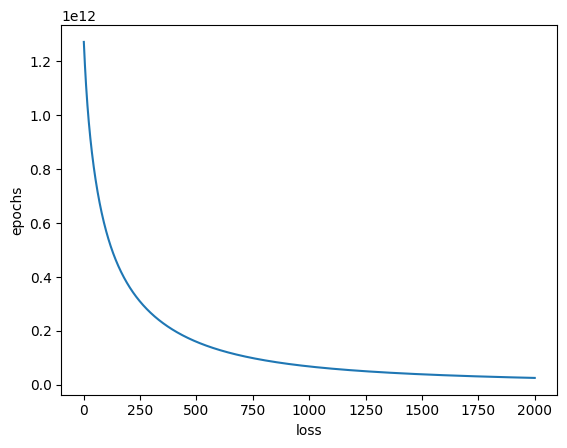

In [158]:
plt.plot(range(1, epochs+1), loss_history)
plt.xlabel('loss')
plt.ylabel('epochs')
plt.show()

# Lets see the process of creation of our image


In [159]:
import numpy as np
frames = [Image.fromarray(img) for img in gen_images]

frames[0].save('gen_image.gif', format='GIF',
    append_images=frames[1:],
    save_all=True,
    duration=len(frames) * 5,
    loop=0
)

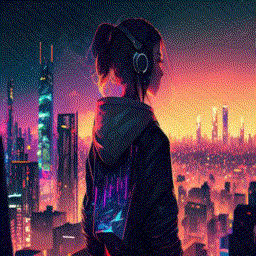

In [160]:
from IPython.display import Image as DisplayImage

DisplayImage(open('gen_image.gif','rb').read())

# Display generated image

In [161]:
content_image = Denormalize(content_image)
style_image = Denormalize(style_image)
gen_image = Denormalize(gen_image)

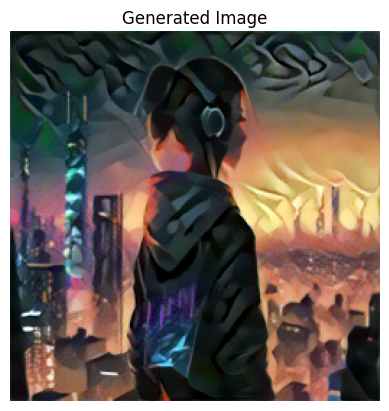

In [162]:
plt.title('Generated Image')
plt.imshow(gen_image.detach().squeeze(0).permute(1, 2, 0).cpu().numpy().clip(0, 1))
plt.axis('off')
plt.show()